In [11]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import shutil

plt.ion()

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
}

data_dir = 'data/unesco'
dsets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dset_loaders = {
    x: torch.utils.data.DataLoader(dsets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dset_sizes = {
    x: len(dsets[x])
    for x in ['train', 'val']
}

dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

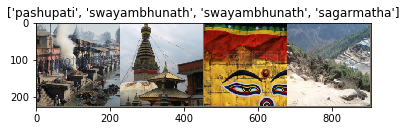

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [dset_classes[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()
    
    best_model = model
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer,epoch)
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dset_loaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _,pred = torch.max(outputs.data,1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(pred == labels.data)
                
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f}'.format(best_acc))
    return best_model

In [15]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return optimizer

In [16]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,10)

if use_gpu:
    model_conv = model_conv.cuda()
    
    
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [18]:
'''
model_conv = train_model(model_conv, criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)
'''

torch.save(model_conv.state_dict(),'unesco10_pytorch_model')